# Processing of smartwatch IMU and Vicon mocap data
PROCESS IMU AND MOCAP DATA
1) Run 001 - unzip data.ipynb first to unzip files and create a valid_files.txt file of subjects and exercises
2) Load IMU data and resample to 50Hz
3) Load mocap data and resample to 50Hz
4) Remove NaNs from mocap data (004.1 Cell 27)
    - If cutting ends, determine how many NaN points are being cut, then also cut same amount of points in IMU data
        - ***Do the number of NaN points get scaled with the resample? otherwise will need to know the original sample rate of the mocap***
5) Compute max(start) and min(end) times across all channels (IMU and mocap)
6) Align IMU and mocap data
7) Merge aligned dfs on reset indices (005.1 C19, L1-18)
8) Reset time index on merged dfs to be regular intervals of 0.02s
 df['time'] = np.linspace(0.0, 0.02*len(df), len(df), dtype='float64')
    - Adding a time column to df
9) Process mocap + IMU based on required features (shoulder orientation, ekf, madgewick, etc.)

In [2]:
import itertools
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

In [3]:
ROOT_PATH = Path("E:/Datasets/0-Processed_Datasets/2023-12-13_imu-vicon-data")
FILTERED_VALID_FILES_PATH = Path(f"{ROOT_PATH}/filtered_valid_files.txt")

## 1) Read valid_files.txt and generate list of imu and mocap files
Note: Run notebook `001 - unzip data.ipynb` to unzip files and create a valid_files.txt file 

In [2]:
with open(Path(f'{ROOT_PATH.joinpath("valid_files.txt")}')) as f:
    valid_files = f.readlines()
    valid_files = [x.strip() for x in valid_files]

mocap_files = [Path(ROOT_PATH.joinpath(f'{file}_mocap.csv')) for file in valid_files]
imu_files = [Path(ROOT_PATH.joinpath(f'{file}_imu.csv')) for file in valid_files]

In [3]:
# FOR TESTING ON ONE FILE
mocap_file = mocap_files[0]
imu_file = imu_files[0]

## 2) Load raw IMU data and resample
Function fo load raw IMU data into df adn resample to 50Hz

In [4]:
def load_imu_df(fp):
    df = pd.read_csv(fp)
    df = df.rename(columns={" Sensor Type": "Sensor Type"})
    subdfs = []
    
    for sensor_type, sensor_name, decimals in zip([1, 2, 4], ["a_", "m_", "g_"], [2, 1, 3]):
        # Select data by sensor type
        subdf = df.loc[df["Sensor Type"] == sensor_type, :].copy()  # Ensure a copy of the DataFrame
        # Check for bad sensor data
        if len(subdf) == 0:
            print(f'Bad IMU file: {fp}')
            break
        # Convert index to datetime and set it
        subdf['Sample Time [s]'] = pd.to_timedelta(subdf['Sample Time [s]'], unit='s')
        subdf.set_index('Sample Time [s]', inplace=True)
        # Deal with the columns
        subdf = subdf.drop(columns=["Sensor Type"])
        new_column_map = {f"val{i}": f"{sensor_name}{i}" for i in range(1, 4)}
        subdf = subdf.rename(columns=new_column_map)

        # Find offset time to make subdf base 20ms
        offset = 0
        if subdf.index[0].value != 0:
            offset = 2e7 - ((subdf.index[0].value) % 2e7)

        subdf = subdf.resample('20ms', offset=offset).mean()  # '20ms' corresponds to 50Hz (1/0.02 = 50)
        
        subdfs.append(subdf.copy())
    
    return subdfs

In [5]:
imu_df = load_imu_df(imu_file)
imu_df[2]

,g_1,g_2,g_3
Sample Time [s],,,
0 days 00:00:00.340000,0.513835,-1.206706,1.320312
0 days 00:00:00.360000,0.547852,-0.923340,1.453125
0 days 00:00:00.380000,0.537842,-0.676025,1.550781
0 days 00:00:00.400000,0.536133,-0.255290,1.678060
0 days 00:00:00.420000,0.526367,0.069153,1.752930
...,...,...,...
0 days 00:00:27.900000,-0.635742,-0.558594,-2.373047
0 days 00:00:27.920000,-0.722900,-0.223938,-2.418945
0 days 00:00:27.940000,-0.819092,0.145752,-2.442383


## 3) Load raw mocap data and resample
Function to load raw mocap into df and resample to 50Hz

In [6]:
def load_mocap_df(fp):
    """Loads mocap data of interest and resamples to 50Hz
    """
    # Read the header of the file to get columns and frequency info
    with open(fp, 'r') as f:
        old_line = ""
        new_line = ""
        frequency = None
        for skip_lines, new_line in enumerate(f):
            if len(old_line.split(",")) > 5:
                break  # Stop when we encounter the first very long header row
            if old_line.lower().strip() == "trajectories":
                frequency = float(new_line.split(",")[0])  # Sometimes frequency has ",hz" on the same line and isnt the same for all captures
            old_line = new_line
    header = old_line.split(",")
    header_markers = [col.split(':')[-1] for col in header]
    # We need radial styloid (RS), ulnar styloid (US), medial epicondyle (ME), and lateral epicondyle (LE)
    # for computing forearm orientation and positions
    markers = ["R_RS", "R_US", "R_ME", "R_LE", "R_ACR", "C7", "T8"]
    col_names = [f"{marker}_{axis}" for marker, axis in itertools.product(markers, "XYZ")]
    col_inds = []
    for marker in markers:
        i = header_markers.index(marker)
        col_inds.extend([i, i+1, i+2])  

    # Sort by names by index, pandas usecols arg uses sorted column order
    col_inds, col_names = list(zip(*sorted(zip(col_inds, col_names))))

    df = pd.read_csv(fp, skiprows=skip_lines + 2, usecols=col_inds, names=col_names)
    df.index = pd.to_timedelta(df.index / frequency, unit="s")
    df = df.resample("20ms").mean()  # Resample to 50 Hz
    return df

In [7]:
mocap_df = load_mocap_df(mocap_file)
mocap_df

,C7_X,C7_Y,C7_Z,T8_X,T8_Y,T8_Z,R_ACR_X,R_ACR_Y,R_ACR_Z,R_LE_X,...,R_LE_Z,R_ME_X,R_ME_Y,R_ME_Z,R_US_X,R_US_Y,R_US_Z,R_RS_X,R_RS_Y,R_RS_Z
0 days 00:00:00,629.4855,209.0275,1159.920,603.6360,469.4435,1167.230,508.2555,142.2965,990.9115,419.5715,...,713.2975,460.2110,174.0285,687.0640,470.2300,-32.490950,497.9325,525.2330,-34.94420,513.7890
0 days 00:00:00.020000,627.8505,212.1270,1160.940,603.2875,472.7585,1167.765,504.0720,145.5525,993.0115,407.9920,...,717.4670,448.7690,178.3785,690.2005,450.9750,-27.948100,500.7730,506.3295,-31.15395,515.1250
0 days 00:00:00.040000,626.3060,215.0325,1161.780,603.0565,475.8785,1168.150,499.8160,148.6870,994.8620,396.5355,...,721.3465,437.3960,183.7115,693.2835,431.7230,-21.662800,503.0940,487.4015,-25.61180,515.8605
0 days 00:00:00.060000,624.8905,217.6930,1162.465,602.9140,478.7330,1168.395,495.6165,151.6950,996.4555,385.4070,...,724.9170,426.4765,189.8745,696.0945,412.7515,-13.580650,504.7880,468.7310,-18.32595,515.9260
0 days 00:00:00.080000,623.6355,220.0645,1162.965,602.8955,481.2930,1168.500,491.5835,154.5200,997.7300,374.8410,...,728.1520,415.7825,197.1635,698.9525,394.4330,-3.793055,505.8730,450.6455,-9.31660,515.3475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0 days 00:00:28.460000,638.6305,245.2605,1116.035,613.9360,500.4025,1083.850,499.8065,180.0745,922.5445,328.3735,...,699.4760,396.2145,344.8110,668.8025,220.3050,259.510000,470.6530,265.9650,227.47750,453.4265
0 days 00:00:28.480000,638.9620,245.1015,1117.700,614.7625,500.3960,1086.050,498.7885,179.2715,927.7900,320.2545,...,707.1115,387.0080,333.7155,672.5975,206.2725,239.141500,483.3695,251.7020,206.78100,466.1905
0 days 00:00:28.500000,639.2465,244.8900,1119.405,615.4860,500.3175,1088.465,498.0305,178.5125,933.1005,313.5405,...,714.0475,379.0940,322.3535,676.8280,195.5325,217.575500,495.3525,240.7240,184.96200,478.5830
0 days 00:00:28.520000,639.4655,244.6480,1121.160,616.1810,500.2230,1091.020,497.5725,177.8730,938.1830,308.1870,...,720.1315,372.1980,310.6665,680.5335,187.4465,195.277000,506.2790,232.9275,162.43250,490.2815


## 4) Remove NaNs from mocap data
NaN Rules:
- If there are more than 2 breakpoints and more than 100 points, don't bother filling, don't use the data
- If there are only 2 breakpoints at the ends, just drop the ends
- If there are less than 100 points but they're in the middle, fill with linear interpolation

In [8]:
nan_files = []
old_nan_series = []

def find_old_nan_files(mocap_files):
    for mocap_file in mocap_files:
        df = load_mocap_df(mocap_file)
        no_nan = df.dropna(axis=0)
        n = len(df)
        m = n - len(no_nan)
        if m == 0:
            continue
        nan_files.append(mocap_file)
        old_nan_series.append(df.isna().any(axis=1).values)
        print(mocap_file.name)
        print(f"\t {m} / {n} = {m/n * 100:.2f}% rows are NaN")

find_old_nan_files(mocap_files)

S01_E7_R_1B_mocap.csv
	 17 / 2359 = 0.72% rows are NaN
S02_E3_R_1_mocap.csv
	 1 / 2542 = 0.04% rows are NaN
S02_E7_R_2_mocap.csv
	 2 / 2795 = 0.07% rows are NaN
S03_E5_R_1_mocap.csv
	 1 / 1933 = 0.05% rows are NaN
S03_E7_R_1_mocap.csv
	 7 / 3418 = 0.20% rows are NaN
S03_E7_R_2_mocap.csv
	 1 / 2716 = 0.04% rows are NaN
S04_E7_R_1_mocap.csv
	 36 / 2555 = 1.41% rows are NaN
S05_E3_R_1_mocap.csv
	 8 / 5303 = 0.15% rows are NaN
S05_E4_R_1_mocap.csv
	 21 / 4108 = 0.51% rows are NaN
S05_E7_R_1_mocap.csv
	 1 / 3496 = 0.03% rows are NaN
S05_E7_R_2_mocap.csv
	 4 / 2861 = 0.14% rows are NaN
S06_E3_R_1_mocap.csv
	 30 / 2783 = 1.08% rows are NaN
S06_E4_R_1_mocap.csv
	 1 / 3413 = 0.03% rows are NaN
S07_E2_R_1_mocap.csv
	 32 / 3758 = 0.85% rows are NaN
S07_E3_R_1_mocap.csv
	 3 / 3064 = 0.10% rows are NaN
S07_E4_R_1_mocap.csv
	 6 / 3392 = 0.18% rows are NaN
S07_E4_R_2_mocap.csv
	 43 / 3057 = 1.41% rows are NaN
S07_E7_R_2_mocap.csv
	 10 / 3308 = 0.30% rows are NaN
S08_E2_R_1_mocap.csv
	 7 / 3685 = 0.19

In [9]:
mocap_timecuts = {}
bad_files = []
nan_series = []
bad_index = []

def remove_nan(mocap_files):
    i = -1
    for mocap_file in mocap_files:
        df = load_mocap_df(mocap_file)
        if len(df) == 0:
            bad_files.append(
                f'{mocap_file.parts[-2]}/{mocap_file.stem.replace("_mocap", "")}'
            )
            continue

        nan_regions = df.isna().any(axis=1).values
        if sum(nan_regions) == 0:
            mocap_timecuts.setdefault("file", []).append(
                f'{mocap_file.parts[-2]}/{mocap_file.stem.replace("_mocap", "")}'
            )
            mocap_timecuts.setdefault("start", []).append(df.index[0].value / 1e9)  # ns to seconds
            mocap_timecuts.setdefault("end", []).append(df.index[-1].value / 1e9)
            continue

        breakpoints = np.diff(nan_regions)
        i += 1
        # Drop if more than 100 NaN points
        if (sum(nan_regions) > 100) and (sum(breakpoints) > 2):
            bad_files.append(
                f'{mocap_file.parts[-2]}/{mocap_file.stem.replace("_mocap", "")}'
            )
            bad_index.append(i)
            nan_series.append(nan_regions)
            continue
        # Also drop ones where there are more than 50 missing points at the ends
        if (sum(nan_regions) > 50) and (nan_regions[0] == False) and (nan_regions[-1] == False):
            bad_files.append(
                f'{mocap_file.parts[-2]}/{mocap_file.stem.replace("_mocap", "")}'
            )
            bad_index.append(i)
            nan_series.append(nan_regions)
            continue

        # Fill inner missing values, often just single missing values
        df = df.interpolate(method="linear", axis=0, limit_area="inside")
        
        # If the nan regions on ends are too big, just ignore them
        if sum(nan_regions) / len(nan_regions) > 0.3:
            bad_files.append(
                f'{mocap_file.parts[-2]}/{mocap_file.stem.replace("_mocap", "")}'
            )
            bad_index.append(i)
            nan_series.append(nan_regions)
            continue
        
        df = df.dropna(axis=0)
        nan_regions = df.isna().any(axis=1).values
        nan_series.append(nan_regions)
        # Track new start/endpoints
        mocap_timecuts.setdefault("file", []).append(
            f'{mocap_file.parts[-2]}/{mocap_file.stem.replace("_mocap", "")}'
        )
        mocap_timecuts.setdefault("start", []).append(df.index[0].value / 1e9)  # ns to seconds
        mocap_timecuts.setdefault("end", []).append(df.index[-1].value / 1e9)
 
remove_nan(mocap_files)

Text(0.5, 1.0, 'After NaN cleanup')

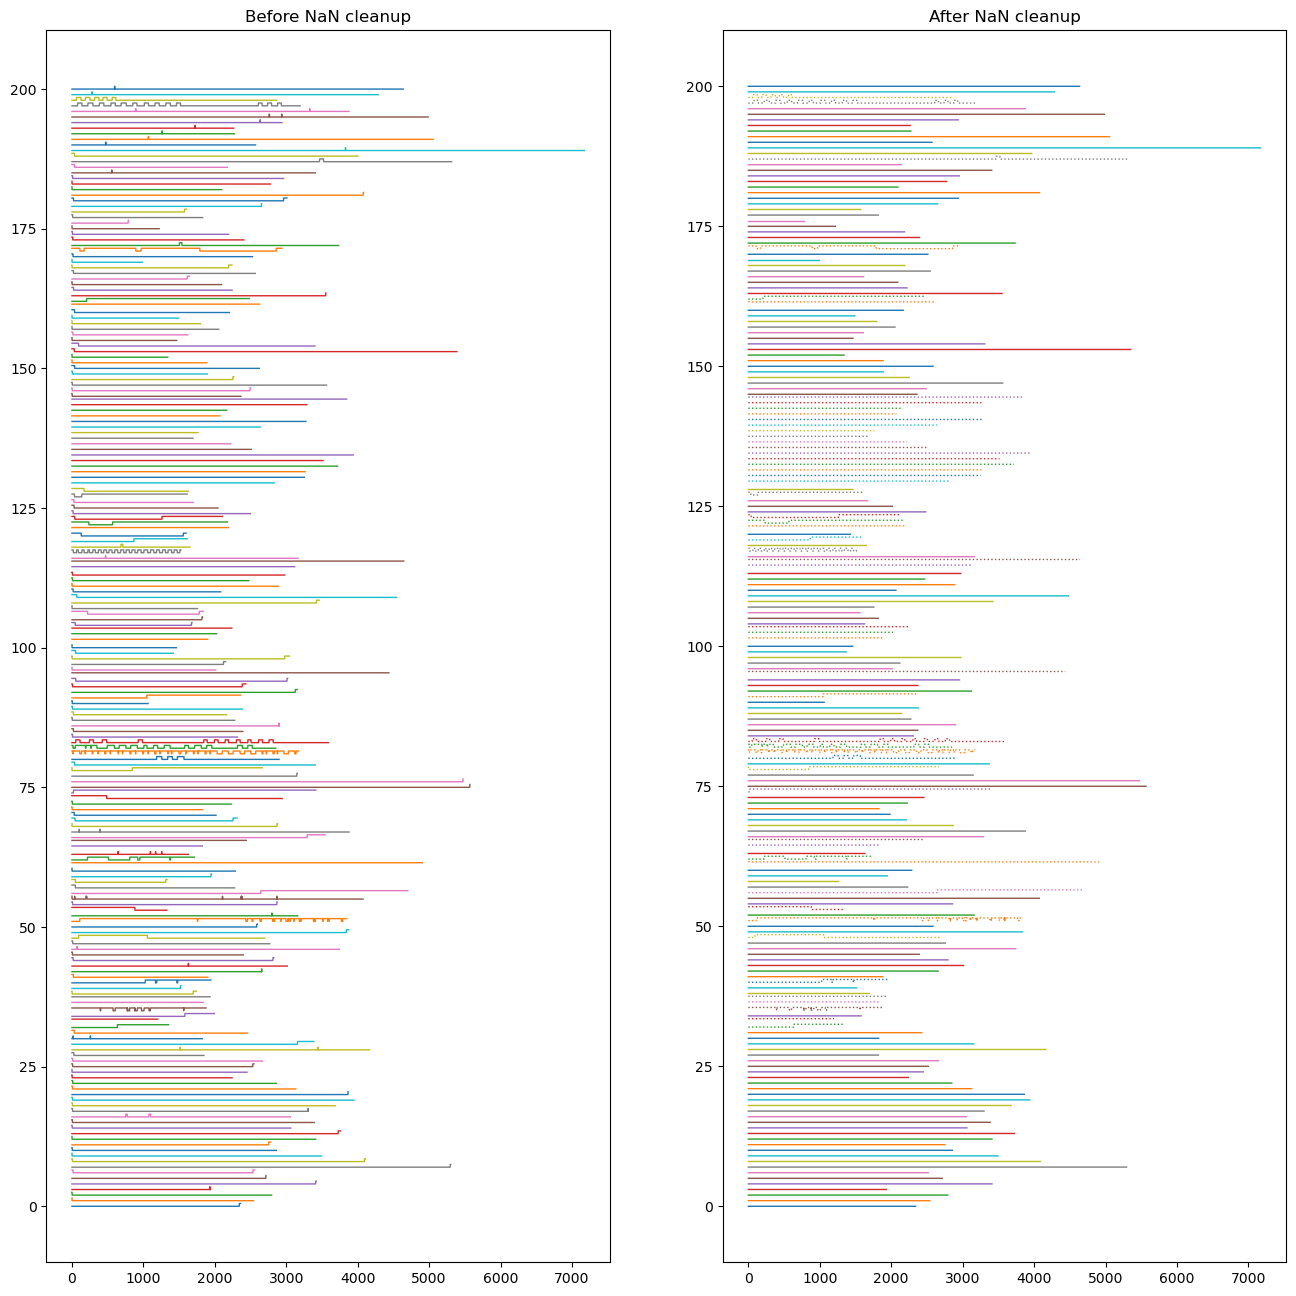

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(16, 16))

for i, bp in enumerate(old_nan_series):
    axs[0].plot(bp / 2 + i, lw=1)
axs[0].set_title("Before NaN cleanup")

for i, bp in enumerate(nan_series):
    if i in bad_index:
        axs[1].plot(bp / 2 + i, linestyle="dotted", lw=1)
    else:
        axs[1].plot(bp / 2 + i, lw=1)
axs[1].set_title("After NaN cleanup")

In [11]:
print(f'# bad files: {len(bad_files)}')

# bad files: 57


In [12]:
df_mocap_timecuts = pd.DataFrame(mocap_timecuts)
df_mocap_timecuts

,file,start,end
0,S01/S01_E1_R_1,0.0,28.54
1,S01/S01_E1_R_2,0.0,23.02
2,S01/S01_E2_R_1,0.0,40.08
3,S01/S01_E2_R_2,0.0,41.08
4,S01/S01_E3_R_1,0.0,50.56
...,...,...,...
1192,S84/S84_E7_R_2,0.0,46.10
1193,S84/S84_E8_R_1,0.0,38.08
1194,S84/S84_E8_R_2,0.0,33.84
1195,S84/S84_E9_R_1,0.0,59.68


## 5) Compare start and end times from mocap and IMU
Previously calculated start and end times from mocap NaN cutting. Now want to get the max(start_time) and min(end_time) from IMU sensor channels

In [13]:
aligned_timecuts = {}
bad_imu_files = []
for file, start, end in zip(df_mocap_timecuts['file'], df_mocap_timecuts['start'], df_mocap_timecuts['end']):
    imu_fp = Path(ROOT_PATH.joinpath(f'{file}_imu.csv'))
    df_imu = load_imu_df(imu_fp)
    start_imu = 0
    end_imu = 1e9
    # Find start and end times of imu data
    for sensor in df_imu:
        if len(sensor) == 0: # check for bad sensors
            bad_imu_files.append(file)
            print(f'Bad IMU file: {file}')
            continue

        if (sensor.index[0].value / 1e9) > start_imu:
            start_imu = sensor.index[0].value / 1e9
        if (sensor.index[-1].value / 1e9) < end_imu:
            end_imu = sensor.index[-1].value / 1e9
    # Compare imu start and end times to mocap start and end times
    if start_imu > start:
        start = start_imu
    if end_imu < end: 
        end = end_imu
    aligned_timecuts.setdefault("file", []).append(file)
    aligned_timecuts.setdefault("start", []).append(round(start, 2))
    aligned_timecuts.setdefault("end", []).append(round(end, 2))

df_timecuts = pd.DataFrame(aligned_timecuts)
df_timecuts

Bad IMU file: E:\Datasets\0-Processed_Datasets\2023-12-13_imu-vicon-data\S22\S22_E3_R_2_imu.csv
Bad IMU file: E:\Datasets\0-Processed_Datasets\2023-12-13_imu-vicon-data\S36\S36_E9_R_2_imu.csv


,file,start,end
0,S01/S01_E1_R_1,0.34,27.96
1,S01/S01_E1_R_2,0.44,22.98
2,S01/S01_E2_R_1,0.28,40.08
3,S01/S01_E2_R_2,0.26,41.08
4,S01/S01_E3_R_1,0.22,50.14
...,...,...,...
1192,S84/S84_E7_R_2,0.20,45.68
1193,S84/S84_E8_R_1,0.14,37.82
1194,S84/S84_E8_R_2,0.14,33.46
1195,S84/S84_E9_R_1,0.06,59.68


Start and end time now reflect the mocap NaN cuts and IMU start and end times

## 6), 7), 8) Align mocap and IMU data to start and end times, merge into new df with all data, and add time column to df

In [15]:
def align_df(df, start, end):
    mask = (df.index > pd.to_timedelta(start*1e9)) & (df.index < pd.to_timedelta(end*1e9))
    df = df[mask]
    # df = df.resample("0.02S").mean()  # Resample to 50 Hz
    # df = df.reset_index(drop=True)
    return df.copy()

In [16]:
all_data = {}

for file, start, end in zip(df_timecuts['file'], df_timecuts['start'], df_timecuts['end']):
    imu_fp = Path(ROOT_PATH.joinpath(f'{file}_imu.csv'))
    mocap_fp = Path(ROOT_PATH.joinpath(f'{file}_mocap.csv'))
    df_imu = load_imu_df(imu_fp)
    df_mocap = load_mocap_df(mocap_fp)

    # Align mocap df
    df_full = align_df(df_mocap, start, end)

    # Align IMU df and append to 
    for sensor in df_imu: # getting to m and g time deltas are off
        sensor = align_df(sensor, start, end)
        df_full = df_full.merge(sensor, left_index=True, right_index=True)

    if len(df_full) == 0:
        print(f'Empty df from {file}')
        continue

    df_full['time'] = np.linspace(0.0, 0.02*len(df_full), len(df_full), dtype='float64')

    all_data[file] = df_full
    

Bad IMU file: E:\Datasets\0-Processed_Datasets\2023-12-13_imu-vicon-data\S22\S22_E3_R_2_imu.csv
Bad IMU file: E:\Datasets\0-Processed_Datasets\2023-12-13_imu-vicon-data\S36\S36_E9_R_2_imu.csv


Note: Bad files are missing some sensor data

In [17]:
all_data[valid_files[2]]

,C7_X,C7_Y,C7_Z,T8_X,T8_Y,T8_Z,R_ACR_X,R_ACR_Y,R_ACR_Z,R_LE_X,...,a_1,a_2,a_3,m_1,m_2,m_3,g_1,g_2,g_3,time
0 days 00:00:00.300000,797.3945,241.7465,1479.495,865.9295,277.1455,1229.915,634.4420,420.1125,1446.975,444.3805,...,8.269531,-5.281250,9.265625,-48.781250,13.195312,-20.890625,0.329834,1.281250,-0.137207,0.00000
0 days 00:00:00.320000,798.3440,240.9295,1479.360,866.9430,276.6410,1229.830,637.4630,419.8800,1448.450,440.7905,...,7.875000,-5.527344,9.371094,-47.218750,12.148438,-24.195312,0.339355,1.382324,-0.167603,0.02001
0 days 00:00:00.340000,799.2735,240.0645,1479.185,868.2055,276.6035,1229.740,640.5770,419.5815,1450.065,437.1750,...,7.482422,-5.423828,8.996094,-46.953125,11.546875,-25.242188,0.231323,1.509277,-0.190430,0.04002
0 days 00:00:00.360000,800.2700,239.2050,1478.955,869.0760,275.4565,1229.495,643.6470,419.2220,1451.685,433.3920,...,7.310547,-5.806641,9.273438,-46.515625,12.144531,-25.992188,0.270752,1.603516,-0.224487,0.06003
0 days 00:00:00.380000,801.2935,238.4290,1478.585,870.1485,274.7985,1229.310,646.6695,418.7425,1453.330,429.5790,...,7.416016,-5.380859,8.996094,-46.000000,12.296875,-26.890625,0.336182,1.719727,-0.245789,0.08004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0 days 00:00:39.980000,784.7755,183.9545,1468.590,867.0225,232.7900,1229.920,756.5080,358.8060,1508.070,495.5895,...,2.546875,-3.102539,10.445312,-11.468750,-7.199219,-53.734375,-1.205566,-1.700684,-0.137238,39.69996
0 days 00:00:40,784.1210,184.7295,1468.905,866.9730,233.6335,1230.210,752.5565,360.7910,1507.520,490.8245,...,2.776367,-2.699219,10.234375,-14.664062,-6.000000,-53.000000,-1.042480,-1.777832,-0.243103,39.71997
0 days 00:00:40.020000,783.4130,185.6670,1469.565,866.8320,234.3255,1230.725,748.6510,362.9325,1507.030,486.3730,...,2.812500,-3.256836,8.929688,-15.539062,-5.398438,-52.687500,-1.001221,-1.875000,-0.269043,39.73998
0 days 00:00:40.040000,782.8050,186.8540,1470.200,866.7235,235.0770,1231.325,744.6250,365.3015,1506.605,482.2355,...,3.388672,-3.550781,9.777344,-17.265625,-5.097656,-51.500000,-0.937256,-2.009766,-0.204285,39.75999


### 8.1) Save dfs to csv and generate filtered_valid_files.txt

In [22]:
filtered_valid_files = []
for file, df in tqdm(all_data.items()):
    save_path = Path(ROOT_PATH.joinpath(f'{file}_full.csv'))
    df.to_csv(save_path, index=False)
    filtered_valid_files.append(file)

with open(FILTERED_VALID_FILES_PATH, "w") as f:
    for line in sorted(filtered_valid_files):
        f.writelines([line + '\n'])

100%|██████████| 1197/1197 [01:57<00:00, 10.22it/s]


## 9) Process aligned data
### 9.1) Transform mocap data

In [25]:
def get_Tmatrix(df):
    """Get the transformation matrix from the first datapoint of an exercise
    """
    df = df.dropna(axis=0)  # For stats, drop NA rows
    if len(df) == 0:
        raise ValueError("0 length dataframe")
    # get marker positions
    p_acr = df.loc[:, ["R_ACR_X", "R_ACR_Y", "R_ACR_Z"]].values[0]
    p_c7 = df.loc[:, ["C7_X", "C7_Y", "C7_Z"]].values[0]
    p_t8 = df.loc[:, ["T8_X", "T8_Y", "T8_Z"]].values[0]
    # get unit axis vectors
    u = p_t8 - p_c7
    u_hat = u / np.linalg.norm(u) # inferior direction
    v = p_acr - p_c7
    v_hat = v / np.linalg.norm(v) # lateral direction
    x = np.cross(v_hat, u_hat) # anterior direction
    x_hat = x / np.linalg.norm(x) # not orthogonal unit vectors, therefore calc x_hat (results in anterior)
    y_hat = -u_hat # negative direction (superior direction)
    z_hat = np.cross(x_hat, y_hat) # y_hat and x_hat are orthogonal
    # get rotation matrix
    R = np.vstack([
        x_hat,
        y_hat,
        z_hat
    ]).T
    # get transformation matrix
    T_torso = np.vstack([np.hstack([R, p_acr[:, None]]), [0, 0, 0, 1]])
    inv_T_torso = np.linalg.inv(T_torso)

    return inv_T_torso

In [26]:
def apply_transformation(positions, inv_T):
    """
    Application of the transformation matrix to transform frame of reference
    """
    positions_homogeneous = np.hstack([positions, np.ones((len(positions), 1))])
    transformed_positions = np.matmul(inv_T, positions_homogeneous.T).T[:, :-1]
    return transformed_positions

In [27]:
def transform_data(df, inv_T):
    df = df.dropna(axis=0)  # For stats, drop NA rows
    if len(df) == 0:
        raise ValueError("0 length dataframe")

    marker_columns = ["R_RS", "R_US", "R_ME", "R_LE", "R_ACR"]
    positions = []

    for marker in marker_columns:
        marker_positions = df.loc[:, [f"{marker}_{axis}" for axis in "XYZ"]].values
        positions.append(marker_positions)

    additional_positions = {
        "R_ELB": (positions[2] + positions[3]) / 2,
        "R_WRIST": (positions[1] + positions[0]) / 2
    }

    positions.extend(list(additional_positions.values()))

    # Apply transformation to all positions
    transformed_positions = [apply_transformation(pos, inv_T) for pos in positions]

    # Create a DataFrame with the transformed positions
    columns = [f"TFM_{marker}_{axis}" for marker in marker_columns + list(additional_positions.keys()) for axis in "XYZ"]
    transformed_df = pd.DataFrame(np.hstack(transformed_positions), columns=columns)

    return transformed_df

In [28]:
with open(FILTERED_VALID_FILES_PATH) as f:
    aligned_valid_files = f.readlines()
    aligned_valid_files = [x.strip() for x in aligned_valid_files]
files = [Path(ROOT_PATH.joinpath(f'{file}_full.csv')) for file in aligned_valid_files]

In [29]:
# Convert mocap position with transformation matrix
missing = []
for file in tqdm(files):
    try:
        df = pd.read_csv(file)
        
        # Apply transformation
        inv_T = get_Tmatrix(df)
        df_tfm = transform_data(df, inv_T)
        df_processed = pd.concat([df, df_tfm], axis=1)
        df_processed.to_csv(Path(ROOT_PATH.joinpath(f'{file.parent}/{file.stem}_processed.csv')), index=False)
    except Exception as e:
        print(f"Error with {file}")
        missing.append({file: e})
        continue

print(f'Number of files with missing data: {len(missing)}')

100%|██████████| 1197/1197 [03:31<00:00,  5.65it/s]

Number of files with missing data: 0


In [30]:
df_processed

,C7_X,C7_Y,C7_Z,T8_X,T8_Y,T8_Z,R_ACR_X,R_ACR_Y,R_ACR_Z,R_LE_X,...,TFM_R_LE_Z,TFM_R_ACR_X,TFM_R_ACR_Y,TFM_R_ACR_Z,TFM_R_ELB_X,TFM_R_ELB_Y,TFM_R_ELB_Z,TFM_R_WRIST_X,TFM_R_WRIST_Y,TFM_R_WRIST_Z
0,928.061,479.547,604.827,1028.47,691.312,566.279,943.588,524.543,802.609,1053.37,...,76.474493,1.136868e-13,0.000000,0.000000,41.297693,-335.215377,41.966206,165.499829,-569.206283,154.914663
1,928.076,479.513,604.831,1028.45,691.298,566.279,943.583,524.544,802.592,1053.33,...,76.455053,5.383704e-03,-0.001537,-0.016842,41.312004,-335.177083,41.947604,165.476432,-569.208181,154.871791
2,928.076,479.511,604.819,1028.43,691.257,566.295,943.493,524.646,802.497,1053.29,...,76.444968,1.325631e-01,-0.069850,-0.098620,41.334093,-335.131888,41.928067,165.491678,-569.161210,154.842661
3,928.069,479.471,604.819,1028.39,691.226,566.298,943.532,524.610,802.480,1053.26,...,76.410401,8.241737e-02,-0.056999,-0.119266,41.359298,-335.104855,41.911599,165.501213,-569.121621,154.850587
4,928.066,479.469,604.805,1028.37,691.184,566.315,943.565,524.557,802.465,1053.19,...,76.339780,3.043458e-02,-0.026130,-0.140897,41.415668,-335.077101,41.862871,165.488452,-569.094711,154.846843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2929,926.361,477.624,590.033,1035.73,688.745,555.336,954.657,480.675,758.802,1028.37,...,72.148191,-2.752201e+01,27.323191,-49.618137,35.444651,-298.928487,33.577530,323.698087,-276.866615,37.733413
2930,926.376,477.469,589.982,1035.82,688.434,555.081,954.468,480.380,759.203,1029.31,...,70.432220,-2.748641e+01,27.731193,-49.277823,34.731957,-299.358322,32.022472,324.340429,-293.833694,41.580313
2931,926.353,477.303,589.995,1035.90,688.189,554.844,954.032,480.230,759.565,1030.01,...,69.093195,-2.716472e+01,28.108004,-48.964511,34.108582,-299.558517,30.964174,324.039257,-310.285197,44.994071
2932,926.298,477.149,590.018,1035.97,687.990,554.683,953.629,480.046,760.011,1030.45,...,67.999439,-2.688946e+01,28.514811,-48.572180,33.751812,-299.656708,30.218371,323.040637,-326.129547,48.178878


## 9.2) Apply Madgewick Filter to IMU data